# Implicit functions in pytorch

*Thomas Viehmann, tv@lernapparat.de*

Sometimes, we do not know the mapping of functions we wish to apply, but only an equation that describes the mapping. In mathematical terms, we wish to apply $f : \mathbb{R}^n \rightarrow \mathbb{R}^m$ of which we only know that $F(x,f(x))=0$ for some function $F : \mathbb{R}^n \times \mathbb{R}^m \rightarrow \mathbb{R}$.

This is the realm of the [implicit function theorem](https://en.wikipedia.org/wiki/Implicit_function_theorem). 
Under reasonable conditions (smoothness, the right sort of nondegenerate derivatives), you have the following:
Given $x,y$ such that $F(x,y) = 0$ there is a neighborhood $U\ni x$ and a function $f$ such that $f(x)=y$ and $F(x,f(x))=0$. And if $F$ is nice enough, we can also compute the derivative of $f$ at $x$, namely  $\frac{df}{dx}(x) = - (\frac{dF}{dy}(x,y))^{-1} \frac{dF}{dx}(x,y)$.

There is an example below.

Nice. As computing the entire matrix Jacobian with respect to $y$ is not that straightforward in pytorch, though, we will stick with just the scalar case.

Let us not be lazy about it and get our hands dirty. First import everything.

In [1]:
import torch
import numpy
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

Now we can turn to the implicit function. In evaluating $f(x)=y$, we need to actually search for the solution $y$ to $F(x,y)=0$. We do this by searching for a minimum of $(F(x,y))^2$, but we also need to provide a starting point $y_0$ near which to look. (And indeed, in the circle example below, we will have two solutions and it would typically be a problem when these are close.)

We use the pytorch LBFGS optimizer for a limited number of steps. Note that LBFGS also has other stopping criteria, so this really is a bound, in fact, achieving the other critera can be considered success, hitting the maximal number of iterations might be considered failure to find the minimum. The scipy optimization documentation has more details. In order for LBFGS to work, you need to provide a function that re-evaluates $F^2$ and the gradient as the `closure` argument to the `step` call.

~~As we need to call `backward` on `F` for the gradient computation and I ran into locking problems when doing so in `Implicit`'s backward method, we compute the required $\frac{dF}{dx}$ and $\frac{dF}{dy}$ in the forward. In fact we precompute $-\frac{df}{dx}$ and save it to the context `ctx`. In the `backward`, we wrap the saved result in a variable and multiply by the `output_grad` to do our step in the backpropagation.~~ PyTorch is ever improving - for the 0.4 update, I moved the derivative calculation in the backward.

We compute the required $\frac{dF}{dx}$ and $\frac{dF}{dy}$ by calling backward in the backward. I don't know if all `detach` are needed or if some of the tensors are pre-detached, but I'm going to play it safe here.

In [2]:
class Implicit(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, y0, F, max_iter=100):
        with torch.enable_grad():
            y = y0.clone().detach().requires_grad_()
            xv = x.detach()
            opt = torch.optim.LBFGS([y], max_iter=max_iter)
            def reevaluate():
                opt.zero_grad()
                z = F(xv,y)**2
                z.backward()
                return z
            opt.step(reevaluate)
        ctx._the_function = F
        ctx.save_for_backward(x, y)
        return y
    @staticmethod
    def backward(ctx, output_grad):
        x, y = ctx.saved_tensors
        F = ctx._the_function
        with torch.enable_grad():
            xv = x.detach().requires_grad_()
            y = y.detach().requires_grad_()
            z = F(xv,y)
            z.backward()
        return -xv.grad/y.grad*output_grad, None, None, None


So now that we have a cool new `autograd` function, let us apply it to an example (and I must admit, I just took it from the Wikipedia page, the application I have in mind needs more context).

The unit circle in the plane can be described by the equation $x^2+y^2 = 1$ or, equivalently $F(x,y) := x^2+y^2-1 = 0$. So let us define $F$.

In [3]:
def circle(x,y):
    return x**2+y**2-1

Everybody loves pictures, let us plot $F$ (the blue grid). In black is the circle $F(x,y)=0$.

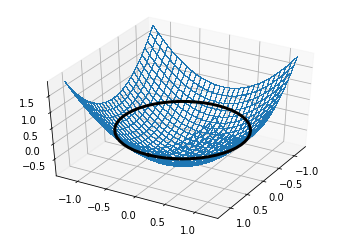

In [4]:
x = numpy.linspace(-1.2,1.2,30)
y = numpy.linspace(-1.2,1.2,30)
t = numpy.linspace(0, 2*numpy.pi)
xx = numpy.repeat(x, len(y)).reshape(x.shape[0],y.shape[0])
yy = numpy.tile(y, (len(x),)).reshape(x.shape[0],y.shape[0])


fig = pyplot.figure()
ax = fig.gca(projection='3d')
ax.plot_wireframe(xx,yy,circle(xx,yy),cmap=pyplot.cm.coolwarm_r,
                       linewidth=0.01, antialiased=False)
ax.plot(numpy.cos(t),numpy.sin(t), 0, linewidth=3, c="black")
ax.view_init(elev=40., azim=30)


Now we can pick a point $x$, say $1/2$ and seek the matching $y=f(x)$ on the circle, starting from $\frac{1}{2}$. We know that actually $y = f(x) = \sqrt{1-x^2} = \frac{\sqrt{3}}{2}$. Of course, we would run into trouble for $x$ close to $1$ or $-1$.

In [5]:
x = torch.tensor([0.5], dtype=torch.double, requires_grad=True)
y0 = torch.tensor([0.5], dtype=torch.double)
y= Implicit.apply(x, y0, circle)
print (y.item(), (1-0.5**2)**0.5)

0.8660251031723489 0.8660254037844386


Works! Let us compute the derivative. We can do that by hand, using the implicit function theorem, we have $\frac{d}{dx} F(x,y) = 2x$ and $\frac{d}{dy} F(x,y) = 2y$, so $\frac{df}{dx}(x) = - x/y$. That is about the technical complication I can handle.

If we didn't like using the implicit function theorem, we would have to do this by $\frac{d}{dx} f(x) = \frac{d}{dx} f(x) = \frac{1}{2} \frac{-2x}{\sqrt{1-x^2}}$ and plugging back in $x$ and $y$ we see that $\frac{d}{dx} f(x) = -\frac{x}{y}$.

But of course, we can also let the autograd do its thing:

In [6]:
y.backward()
x.grad.shape, y.shape

(torch.Size([1]), torch.Size([1]))

Awesome. In fact, we can also use `pytorch`'s automated checker (and indeed this is why I used `DoubleTensor`s, as the gradient checker can be too strict to use single precision floats). It seems that gradcheck does not like the 1d $x$.

In [7]:
torch.autograd.gradcheck(lambda x: Implicit.apply(x.unsqueeze(0),y0,circle), x)

True

So this toy example works great. But is the implicit function really useful?
One thing is that the limitation to scalar $x$ and $y$ is quite severe.

Quite likely, this is only the case for very specific use cases. In general, more common alternatives are
- Manually solving for the implicit function.
- Adding a free parameter $y$ and introduce a penalty $\lambda F(x,y)^2$ into the loss function.

However, when there is just this last transformation you want to add and a free $y$ isn't a good option for you, this might be nice to have.

I hope you enjoyed this little feature, your feedback is very welcome. I read and appreciate every email you send to <tv@lernapparat.de>.

Thomas